In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from DBCV import DBCV
from scipy.spatial.distance import euclidean
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (15,7)

# Test data

In [2]:
# test data
labels_true = np.concatenate((np.full(100, 1), np.full(75, 2), np.full(100, 3), np.full(75, 4)))
x1 = np.concatenate( (np.random.normal(10,6,100), np.random.normal(2,0.5,75), np.random.normal(10,1,100), np.random.normal(-3,0.5,75) ))
x2 = np.concatenate((np.random.normal(10,1,100), np.random.normal(2,1,75), np.random.normal(10,6,100), np.random.normal(20,1,75)))
X = np.dstack((x1,x2)).reshape(-1, 2)

In [3]:
# teszt adatok
labels_true = np.concatenate((np.full(100, 1), np.full(75, 2), np.full(100, 3), np.full(75, 4)))
x1 = np.concatenate( (np.random.lognormal(10,6,100), np.random.lognormal(2,0.5,75), 
                      np.random.lognormal(10,1,100), np.random.lognormal(-3,0.5,75) ))
x2 = np.concatenate((np.random.lognormal(10,1,100), np.random.lognormal(2,1,75), 
                     np.random.lognormal(10,6,100), np.random.lognormal(20,1,75)))


In [4]:
# transform the lognormal to normal
x1 = np.log(x1)
x2 = np.log(x2)
# stack 
X = np.dstack((x1,x2)).reshape(-1, 2)

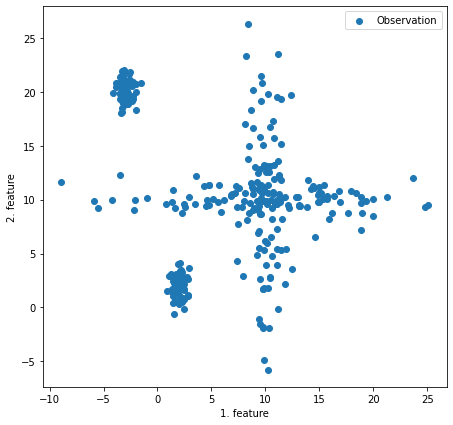

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(x1, x2, label="Observation")
# square plot
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel("1. feature")
plt.ylabel("2. feature")
plt.show()

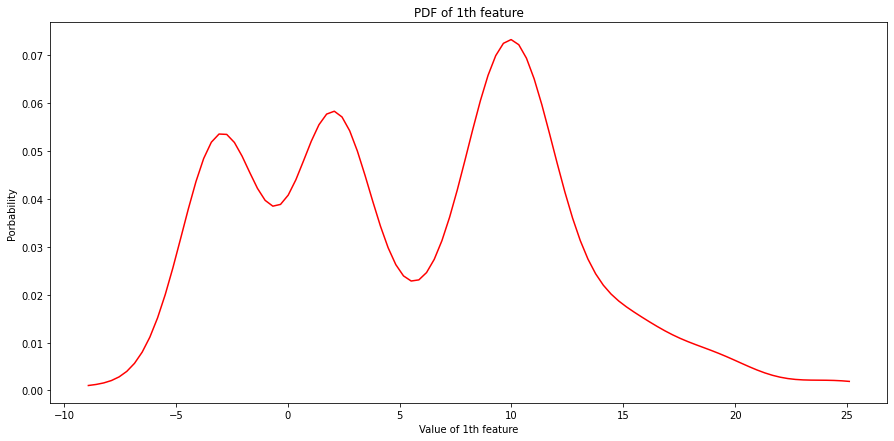

In [6]:
from scipy.stats.kde import gaussian_kde
# obtaining the pdf (my_pdf is a function!)
my_pdf = gaussian_kde(x1, bw_method=0.25)

# plotting the result
x = np.linspace(np.min(x1),np.max(x1),100)
plt.plot(x,my_pdf(x),'r') # distribution function
plt.xlabel("Value of 1th feature")
plt.ylabel("Porbability")
plt.title("PDF of 1th feature")
plt.show()

In [7]:
db = DBSCAN(eps=3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("DBCV: ", DBCV(X, labels, dist_function=euclidean))

Estimated number of clusters: 3
Estimated number of noise points: 13
Homogeneity: 0.714
Completeness: 0.880
Silhouette Coefficient: 0.570
DBCV:  -0.12311111747835801


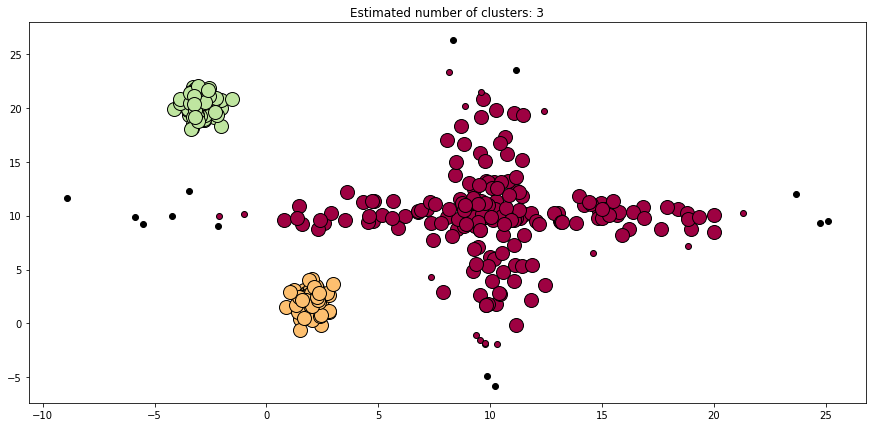

In [8]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# HDBSCAN

In [9]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=10)
labels = clusterer.fit_predict(X)
print(metrics.silhouette_score(X, labels))

0.5691893313708948


<AxesSubplot:ylabel='$\\lambda$ value'>

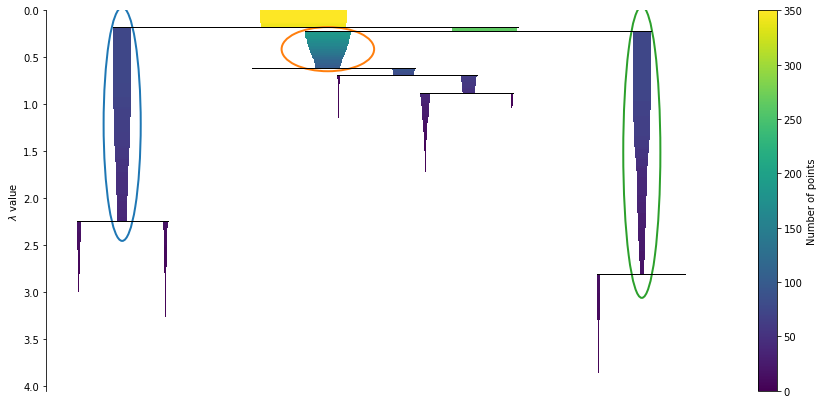

In [10]:
import seaborn as sns
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

<AxesSubplot:ylabel='distance'>

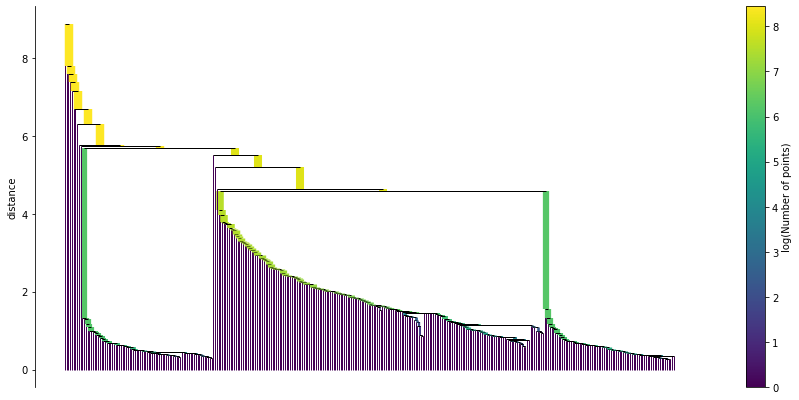

In [11]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Number of cluster 4


No handles with labels found to put in legend.


0.5691893313708948 -0.041466678990824415


<Figure size 1080x504 with 0 Axes>

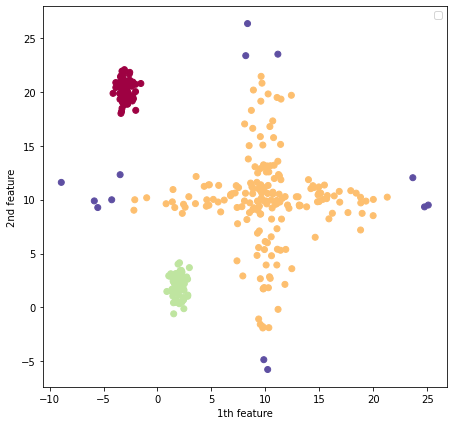

In [12]:
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels)))]
print("Number of cluster", len(set(labels)))
print( metrics.silhouette_score(X, labels), DBCV(X, labels, dist_function=euclidean))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(x1,x2, color=[ colors[i] for i in labels ])
# square plot
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel("1th feature")
plt.ylabel("2nd feature")
plt.show()

#  BayesianGaussianMixture


No handles with labels found to put in legend.


Silhouette_score : 0.548436972208904 DBCV -0.20140740373356794


<Figure size 1080x504 with 0 Axes>

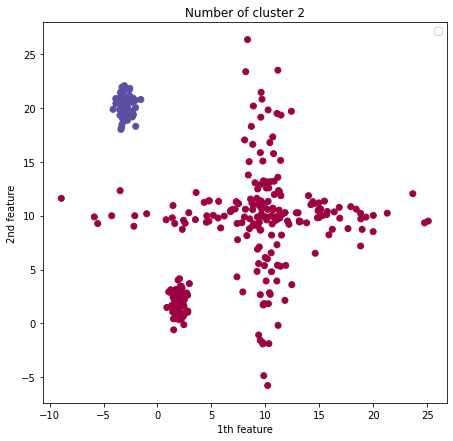

No handles with labels found to put in legend.


Silhouette_score : 0.5546255812267993 DBCV -0.12118910169755305


<Figure size 1080x504 with 0 Axes>

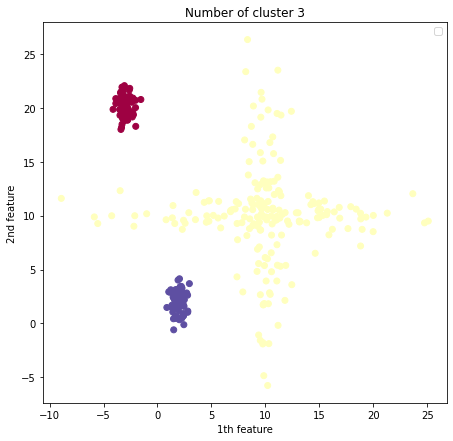

No handles with labels found to put in legend.


Silhouette_score : 0.4081894124591796 DBCV -0.2465185454681052


<Figure size 1080x504 with 0 Axes>

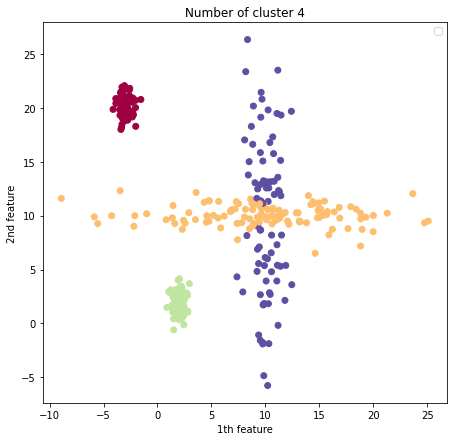

Optimal cluster number: 4


In [13]:
from sklearn.mixture import BayesianGaussianMixture

# optimal number of cluster
optimal_nc = 0
best_model = None

for nc in range(2,7):
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, nc)]

    dpgmm = BayesianGaussianMixture(n_components=nc, covariance_type="full").fit(X)
    labels = dpgmm.predict(X)
    
    # do not compute more if we found the optimal cluster number
    if len(set(labels)) == optimal_nc:
        break
    else:
        optimal_nc = len(set(labels))
        best_model = dpgmm
        
    print("Silhouette_score", ":", metrics.silhouette_score(X, labels), 
          "DBCV", DBCV(X, labels, dist_function=euclidean))
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter(x1,x2, color=[ colors[i] for i in labels ])
    # square plot
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title(f"Number of cluster {len(set(labels))}")
    plt.xlabel("1th feature")
    plt.ylabel("2nd feature")
    plt.show()

print(f"Optimal cluster number: {optimal_nc}")

Text(0.5, 1.0, 'Bayesian clustering')

<Figure size 1080x504 with 0 Axes>

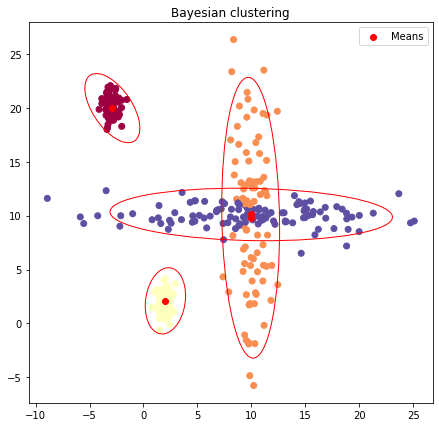

In [14]:
# source: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=1.96, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D()
    transf = transf.rotate_deg(45) 
    transf = transf.scale(scale_x, scale_y) 
    transf = transf.translate(np.array(mean_x), np.array(mean_y))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot()
# square plot
ax.set_aspect('equal', adjustable='box')
plt.scatter(x1,x2, color=[ colors[i] for i in labels ])
plt.scatter(best_model.means_[:,0], best_model.means_[:,1], color="red", label="Means")
# plot bounds
for i in range(optimal_nc):
    confidence_ellipse(best_model.means_[i,0], best_model.means_[i,1], 
                       best_model.covariances_[i], ax, edgecolor='red')
    
plt.legend()
plt.title("Bayesian clustering")


## Probabilistic result of the clusters

In [15]:
# probabilities for each cluster
prob =  best_model.predict_proba(X)

In [16]:
# filter out too small prob and round biggers one
prob[prob < 0.05] = 0
prob[prob >= 0.95] = 1
# normalization
prob = prob/prob.sum(axis=1, keepdims=True)
# probability lables
labels_prob = np.array([ True if max(prob[i]) < 1 else False for i in range(prob.shape[0]) ])

In [17]:
print(prob)

[[0.         0.93883855 0.         0.06116145]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 ...
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]]


<Figure size 1080x504 with 0 Axes>

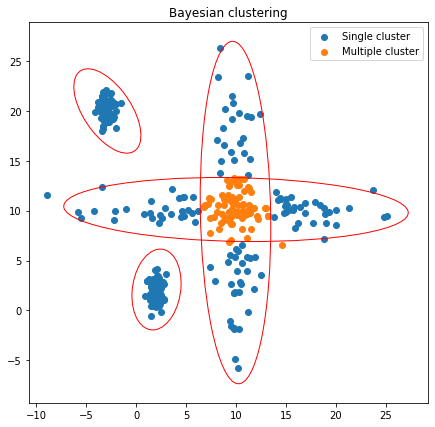

In [22]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot()
# square plot
ax.set_aspect('equal', adjustable='box')
plt.scatter(x1[~labels_prob], x2[~labels_prob], label="Single cluster")
plt.scatter(x1[labels_prob], x2[labels_prob], label="Multiple cluster")
for i in range(optimal_nc):
    confidence_ellipse(best_model.means_[i,0], best_model.means_[i,1], 
                       best_model.covariances_[i], ax, 
                       n_std=2.58, edgecolor='red')
plt.legend()
plt.title("Bayesian clustering")
plt.show()